In [2]:
!nvidia-smi

Tue Dec 17 19:33:06 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   52C    P8             12W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Initialize autoML

In [3]:
import h2o
print(h2o.__version__)
from h2o.automl import H2OAutoML

h2o.init(max_mem_size='16G')

3.46.0.6
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.25" 2024-10-15; OpenJDK Runtime Environment (build 11.0.25+9-post-Ubuntu-1ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.25+9-post-Ubuntu-1ubuntu122.04, mixed mode, sharing)
  Starting server from /opt/conda/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpi7_y8hf5
  JVM stdout: /tmp/tmpi7_y8hf5/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpi7_y8hf5/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,1 month and 15 days
H2O_cluster_name:,H2O_from_python_unknownUser_sgzhy8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,16 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


# Import libraries

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [5]:
pd.set_option('display.max_columns', None)

# Import Data

In [ ]:
train = pd.read_csv('/home/onyxia/work/Insurance-Premium/train_1.csv')
test = pd.read_csv('/home/onyxia/work/Insurance-Premium/test_1.csv')
sample = pd.read_csv('/home/onyxia/work/Insurance-Premium/sample_submission.csv')

In [7]:
sample.head()

,id,Premium Amount
0,1200000,1102.545
1,1200001,1102.545
2,1200002,1102.545
3,1200003,1102.545
4,1200004,1102.545


In [8]:
test.head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type
0,1200000,28.0,Female,2310.0,NaN,4.0,Bachelor's,Self-Employed,7.657981,Rural,Basic,NaN,19.0,NaN,1.0,2023-06-04 15:21:39.245086,Poor,Yes,Weekly,House
1,1200001,31.0,Female,126031.0,Married,2.0,Master's,Self-Employed,13.381379,Suburban,Premium,NaN,14.0,372.0,8.0,2024-04-22 15:21:39.224915,Good,Yes,Rarely,Apartment
2,1200002,47.0,Female,17092.0,Divorced,0.0,PhD,Unemployed,24.354527,Urban,Comprehensive,NaN,16.0,819.0,9.0,2023-04-05 15:21:39.134960,Average,Yes,Monthly,Condo
3,1200003,28.0,Female,30424.0,Divorced,3.0,PhD,Self-Employed,5.136225,Suburban,Comprehensive,1.0,3.0,770.0,5.0,2023-10-25 15:21:39.134960,Poor,Yes,Daily,House
4,1200004,24.0,Male,10863.0,Divorced,2.0,High School,Unemployed,11.844155,Suburban,Premium,NaN,14.0,755.0,7.0,2021-11-26 15:21:39.259788,Average,No,Weekly,House


# Preprocessing and Feature Engineering

In [9]:
train.head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,Comprehensive,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,Basic,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,Premium,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0


In [10]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,1200000.0,599999.500000,346410.305851,0.000000,299999.750000,599999.500000,899999.250000,1.199999e+06
Age,1181295.0,41.145563,13.539950,18.000000,30.000000,41.000000,53.000000,6.400000e+01
Annual Income,1155051.0,32745.217777,32179.506124,1.000000,8001.000000,23911.000000,44634.000000,1.499970e+05
Number of Dependents,1090328.0,2.009934,1.417338,0.000000,1.000000,2.000000,3.000000,4.000000e+00
Health Score,1125924.0,25.613908,12.203462,2.012237,15.918959,24.578648,34.527209,5.897591e+01
Previous Claims,835971.0,1.002689,0.982840,0.000000,0.000000,1.000000,2.000000,9.000000e+00
Vehicle Age,1199994.0,9.569889,5.776189,0.000000,5.000000,10.000000,15.000000,1.900000e+01
Credit Score,1062118.0,592.924350,149.981945,300.000000,468.000000,595.000000,721.000000,8.490000e+02
Insurance Duration,1199999.0,5.018219,2.594331,1.000000,3.000000,5.000000,7.000000,9.000000e+00
Premium Amount,1200000.0,1102.544822,864.998859,20.000000,514.000000,872.000000,1509.000000,4.999000e+03


In [11]:
target = (set(train.columns) - set(test.columns)).pop()

print(f"Target column: {target}")
print(f"Data type: {train[target].dtype}")

Target column: Premium Amount
Data type: float64


In [12]:
train_info={
    'Data Type': train.dtypes,
    'Missing Values(MV)': train.isnull().sum(),
    'MV percentage(%)' : train.isnull().mean() * 100,
    'Unique Values': train.nunique()
}

train_summary = pd.DataFrame(train_info)
train_summary

,Data Type,Missing Values(MV),MV percentage(%),Unique Values
id,int64,0,0.000000,1200000
Age,float64,18705,1.558750,47
Gender,object,0,0.000000,2
Annual Income,float64,44949,3.745750,88593
Marital Status,object,18529,1.544083,3
Number of Dependents,float64,109672,9.139333,5
Education Level,object,0,0.000000,4
Occupation,object,358075,29.839583,3
Health Score,float64,74076,6.173000,532657
Location,object,0,0.000000,3


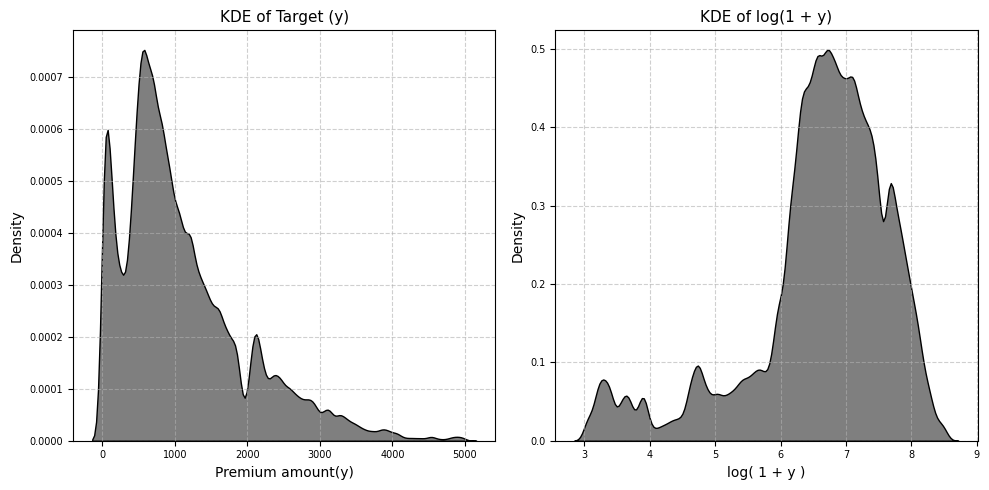

In [13]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.kdeplot(train[target], fill=True, color='black', alpha=0.5)
plt.title('KDE of Target (y)', fontsize=11)
plt.xlabel('Premium amount(y)', fontsize=10)
plt.ylabel('Density', fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=7)
plt.grid(True, linestyle='--', alpha=0.6)


y_train_log = np.log1p(train[target])
plt.subplot(1, 2, 2)
sns.kdeplot(y_train_log, fill=True, color='black', alpha=0.5)
plt.title(f'KDE of log(1 + y)', fontsize=11)
plt.xlabel(f'log( 1 + y )', fontsize=10)
plt.ylabel('Density', fontsize=10)
plt.tick_params(axis='both', which='major', labelsize=7)
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [14]:
datetime_columns = train.select_dtypes(include=['object']).columns

for col in datetime_columns:
    try:
        # Convert the column to datetime format
        train[col] = pd.to_datetime(train[col], errors='raise')
        test[col] = pd.to_datetime(test[col], errors='raise')
        
        # Convert datetime to epoch time
        train[col] = train[col].astype(np.int64) / 10**9
        test[col] = test[col].astype(np.int64) / 10**9

        print(f"Converted '{col}' to epoch time.")
    except Exception:
        continue

Converted 'Policy Start Date' to epoch time.


## Missing Value

In [15]:
# Fill missing values in numeric columns
numeric_columns = train.select_dtypes(include=['number']).columns
for col in numeric_columns:
    if col in test.columns:
        median_value = train[col].median()  # Calculate the median
        train[col].fillna(median_value, inplace=True)
        test[col].fillna(median_value, inplace=True)

# Fill missing values in object columns
object_columns = train.select_dtypes(include=['object']).columns
for col in object_columns:
    if col in test.columns:
        train[col].fillna("Unknown", inplace=True)
        test[col].fillna("Unknown", inplace=True)

train.isnull().sum().T

id                      0
Age                     0
Gender                  0
Annual Income           0
Marital Status          0
Number of Dependents    0
Education Level         0
Occupation              0
Health Score            0
Location                0
Policy Type             0
Previous Claims         0
Vehicle Age             0
Credit Score            0
Insurance Duration      0
Policy Start Date       0
Customer Feedback       0
Smoking Status          0
Exercise Frequency      0
Property Type           0
Premium Amount          0
dtype: int64

### Categorical Encoding

In [16]:
le = LabelEncoder()
object_columns = train.select_dtypes(include=['object']).columns
for column_name in object_columns:
    train[column_name] = le.fit_transform(train[column_name])    
    test[column_name] = le.transform(test[column_name])

train.dtypes.T

id                        int64
Age                     float64
Gender                    int64
Annual Income           float64
Marital Status            int64
Number of Dependents    float64
Education Level           int64
Occupation                int64
Health Score            float64
Location                  int64
Policy Type               int64
Previous Claims         float64
Vehicle Age             float64
Credit Score            float64
Insurance Duration      float64
Policy Start Date       float64
Customer Feedback         int64
Smoking Status            int64
Exercise Frequency        int64
Property Type             int64
Premium Amount          float64
dtype: object

### Numerical Normalization

In [17]:
# Select numerical columns
numerical_columns = train.select_dtypes(include=['float64']).columns
numerical_columns = numerical_columns[numerical_columns != target]

# Applying Normalization
scaler = StandardScaler()
train[numerical_columns] = scaler.fit_transform(train[numerical_columns])
test[numerical_columns] = scaler.transform(test[numerical_columns])

In [18]:
train

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,-1.648301,0,-0.707414,1,-0.746862,0,1,-0.249610,2,2,1.216739,1.286338,-1.567375,-0.007023,1.301065,2,0,3,2,2869.0
1,1,-0.159542,0,-0.023289,0,0.733500,2,3,-0.844110,0,1,-0.002284,0.420713,0.714630,-1.163391,0.929018,0,1,1,2,1483.0
2,2,-1.350549,1,-0.215473,0,0.733500,1,1,1.829212,1,2,-0.002284,0.766963,0.013020,-0.777935,1.139973,1,1,3,2,567.0
3,3,-1.499425,1,3.461605,1,-0.006681,0,3,-1.235840,0,0,-0.002284,-1.656788,-1.602810,-1.548847,1.630921,2,1,0,0,765.0
4,4,-1.499425,1,0.228896,2,-0.746862,0,1,-0.437598,0,2,-1.221307,-0.271787,0.034281,-0.392479,-0.141095,2,1,3,2,2022.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,1199995,-0.382856,0,-0.161259,1,-1.487043,2,2,-0.996082,2,2,-0.002284,-0.791163,-1.567375,-0.777935,0.852308,2,0,0,0,1303.0
1199996,1199996,0.957026,1,0.106646,0,-0.006681,2,1,-1.189716,0,1,-0.002284,0.074463,0.027194,-0.392479,0.401632,2,0,3,0,821.0
1199997,1199997,-1.648301,1,0.615826,0,-1.487043,2,3,-0.915601,1,0,-1.221307,1.632588,0.013020,0.378433,-0.505471,1,0,1,1,371.0
1199998,1199998,1.031464,1,-0.268959,2,-0.746862,3,3,-0.592267,1,2,-0.002284,-0.444912,-1.319331,-0.392479,-0.281092,2,0,0,0,596.0


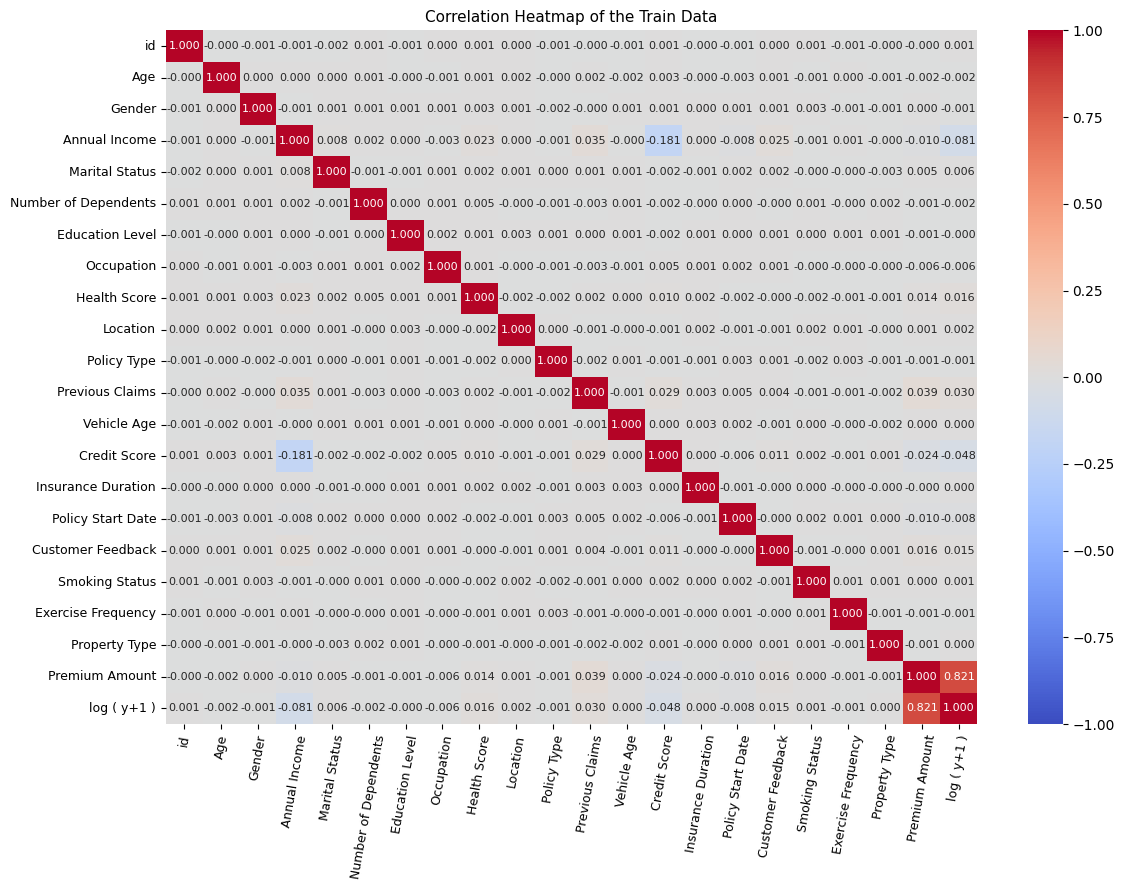

In [19]:
# Select only numeric columns from the training data
numeric_data = train.select_dtypes(include=['number'])

# Add a new column for the log(y+1)
numeric_data['log ( y+1 )'] = np.log1p(train[target])

# Create the heatmap
correlation_matrix = numeric_data.corr()
plt.figure(figsize=(12, 9))
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmax=1, vmin=-1,
                      annot_kws={"size": 8}, fmt=".3f")
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=80, fontsize=9)
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, fontsize=9)

plt.title("Correlation Heatmap of the Train Data", fontsize=11)
plt.tight_layout()
plt.show()

In [20]:
correlation_matrix['Premium Amount'].sort_values(ascending=False)

Premium Amount          1.000000
log ( y+1 )             0.820760
Previous Claims         0.039394
Customer Feedback       0.015772
Health Score            0.013976
Marital Status          0.005356
Location                0.001059
Vehicle Age             0.000391
Smoking Status          0.000163
Gender                  0.000161
Insurance Duration     -0.000028
id                     -0.000292
Policy Type            -0.000884
Number of Dependents   -0.000947
Exercise Frequency     -0.001098
Education Level        -0.001121
Property Type          -0.001222
Age                    -0.002410
Occupation             -0.006059
Annual Income          -0.009989
Policy Start Date      -0.010111
Credit Score           -0.024471
Name: Premium Amount, dtype: float64

Skewness of id: 0.00
Skewness of Age: -0.01
Skewness of Gender: -0.01
Skewness of Annual Income: 1.52
Skewness of Marital Status: 0.09
Skewness of Number of Dependents: -0.01
Skewness of Education Level: -0.02
Skewness of Occupation: -0.10
Skewness of Health Score: 0.31
Skewness of Location: 0.01
Skewness of Policy Type: -0.01
Skewness of Previous Claims: 1.09
Skewness of Vehicle Age: -0.02
Skewness of Credit Score: -0.13
Skewness of Insurance Duration: -0.01
Skewness of Policy Start Date: 0.01
Skewness of Customer Feedback: 0.22
Skewness of Smoking Status: -0.01
Skewness of Exercise Frequency: -0.02
Skewness of Property Type: -0.00
Skewness of Premium Amount: 1.24
Skewness of log ( y+1 ): -1.26


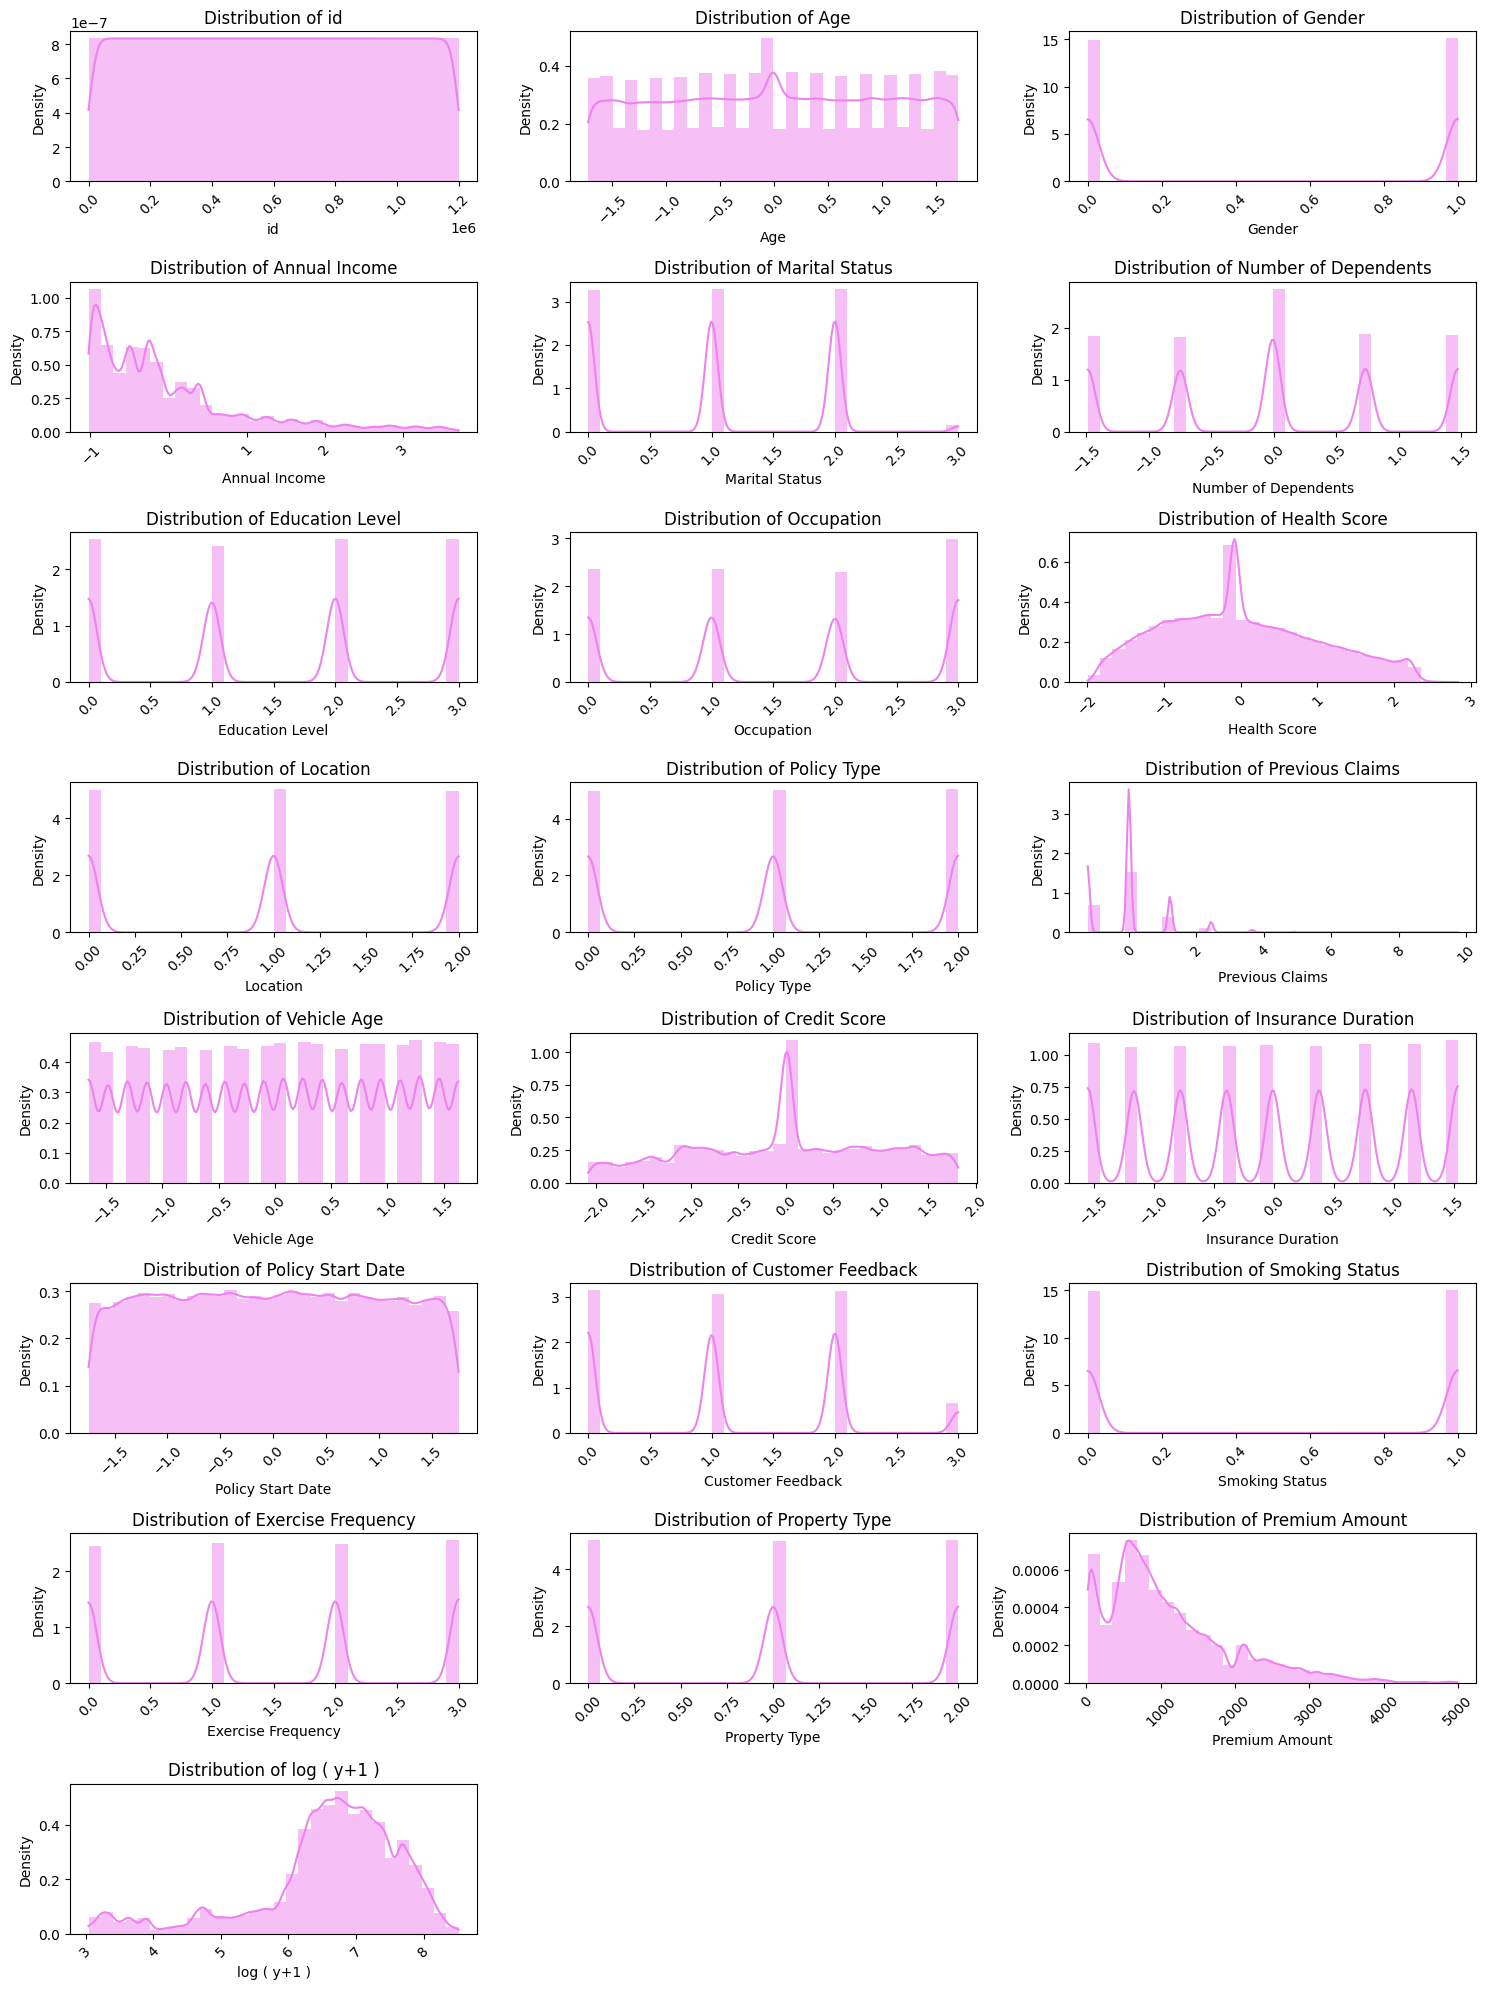

In [21]:
num_cols = numeric_data.columns

plt.figure(figsize=(15, 20))

for i, col in enumerate(num_cols, 1):
    plt.subplot(len(num_cols)//3 + 1, 3, i)
    sns.histplot(numeric_data[col], kde=True, bins=30, color='violet', stat='density', linewidth=0)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.xticks(rotation=45)

    feature_skewness = skew(numeric_data[col].dropna())
    print(f"Skewness of {col}: {feature_skewness:.2f}")

plt.tight_layout()
plt.show()

### Skewed features

In [22]:
# skewed_cols = ['Annual Income', 'Previous Claims', 'Premium Amount']
# for col in skewed_cols:
#     train[col] = np.log1p(train[col])

# skewness_after_log = train[skewed_cols].skew()
# print("Skewness after log transformation:")
# print(skewness_after_log)

In [23]:
numeric_data

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount,log ( y+1 )
0,0,-1.648301,0,-0.707414,1,-0.746862,0,1,-0.249610,2,2,1.216739,1.286338,-1.567375,-0.007023,1.301065,2,0,3,2,2869.0,7.962067
1,1,-0.159542,0,-0.023289,0,0.733500,2,3,-0.844110,0,1,-0.002284,0.420713,0.714630,-1.163391,0.929018,0,1,1,2,1483.0,7.302496
2,2,-1.350549,1,-0.215473,0,0.733500,1,1,1.829212,1,2,-0.002284,0.766963,0.013020,-0.777935,1.139973,1,1,3,2,567.0,6.342121
3,3,-1.499425,1,3.461605,1,-0.006681,0,3,-1.235840,0,0,-0.002284,-1.656788,-1.602810,-1.548847,1.630921,2,1,0,0,765.0,6.641182
4,4,-1.499425,1,0.228896,2,-0.746862,0,1,-0.437598,0,2,-1.221307,-0.271787,0.034281,-0.392479,-0.141095,2,1,3,2,2022.0,7.612337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,1199995,-0.382856,0,-0.161259,1,-1.487043,2,2,-0.996082,2,2,-0.002284,-0.791163,-1.567375,-0.777935,0.852308,2,0,0,0,1303.0,7.173192
1199996,1199996,0.957026,1,0.106646,0,-0.006681,2,1,-1.189716,0,1,-0.002284,0.074463,0.027194,-0.392479,0.401632,2,0,3,0,821.0,6.711740
1199997,1199997,-1.648301,1,0.615826,0,-1.487043,2,3,-0.915601,1,0,-1.221307,1.632588,0.013020,0.378433,-0.505471,1,0,1,1,371.0,5.918894
1199998,1199998,1.031464,1,-0.268959,2,-0.746862,3,3,-0.592267,1,2,-0.002284,-0.444912,-1.319331,-0.392479,-0.281092,2,0,0,0,596.0,6.391917


### Train-Test Splitting

In [24]:
train['log_target'] = np.log1p(train[target])

In [25]:
train

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount,log_target
0,0,-1.648301,0,-0.707414,1,-0.746862,0,1,-0.249610,2,2,1.216739,1.286338,-1.567375,-0.007023,1.301065,2,0,3,2,2869.0,7.962067
1,1,-0.159542,0,-0.023289,0,0.733500,2,3,-0.844110,0,1,-0.002284,0.420713,0.714630,-1.163391,0.929018,0,1,1,2,1483.0,7.302496
2,2,-1.350549,1,-0.215473,0,0.733500,1,1,1.829212,1,2,-0.002284,0.766963,0.013020,-0.777935,1.139973,1,1,3,2,567.0,6.342121
3,3,-1.499425,1,3.461605,1,-0.006681,0,3,-1.235840,0,0,-0.002284,-1.656788,-1.602810,-1.548847,1.630921,2,1,0,0,765.0,6.641182
4,4,-1.499425,1,0.228896,2,-0.746862,0,1,-0.437598,0,2,-1.221307,-0.271787,0.034281,-0.392479,-0.141095,2,1,3,2,2022.0,7.612337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,1199995,-0.382856,0,-0.161259,1,-1.487043,2,2,-0.996082,2,2,-0.002284,-0.791163,-1.567375,-0.777935,0.852308,2,0,0,0,1303.0,7.173192
1199996,1199996,0.957026,1,0.106646,0,-0.006681,2,1,-1.189716,0,1,-0.002284,0.074463,0.027194,-0.392479,0.401632,2,0,3,0,821.0,6.711740
1199997,1199997,-1.648301,1,0.615826,0,-1.487043,2,3,-0.915601,1,0,-1.221307,1.632588,0.013020,0.378433,-0.505471,1,0,1,1,371.0,5.918894
1199998,1199998,1.031464,1,-0.268959,2,-0.746862,3,3,-0.592267,1,2,-0.002284,-0.444912,-1.319331,-0.392479,-0.281092,2,0,0,0,596.0,6.391917


# Train autoML

In [26]:
train_h2o = h2o.H2OFrame(train)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [27]:
train_h2o

id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount,log_target
0,-1.6483,0,-0.707414,1,-0.746862,0,1,-0.24961,2,2,1.21674,1.28634,-1.56737,-0.00702269,1.30106,2,0,3,2,2869,7.96207
1,-0.159542,0,-0.0232895,0,0.7335,2,3,-0.84411,0,1,-0.00228364,0.420713,0.71463,-1.16339,0.929018,0,1,1,2,1483,7.3025
2,-1.35055,1,-0.215473,0,0.7335,1,1,1.82921,1,2,-0.00228364,0.766963,0.0130199,-0.777935,1.13997,1,1,3,2,567,6.34212
3,-1.49942,1,3.46161,1,-0.00668075,0,3,-1.23584,0,0,-0.00228364,-1.65679,-1.60281,-1.54885,1.63092,2,1,0,0,765,6.64118
4,-1.49942,1,0.228896,2,-0.746862,0,1,-0.437598,0,2,-1.22131,-0.271787,0.0342808,-0.392479,-0.141095,2,1,3,2,2022,7.61234
5,-0.903921,1,0.428545,1,-0.746862,0,3,0.634604,2,2,1.21674,-0.964288,0.147672,-0.00702269,0.184925,0,0,3,2,3202,8.07184
6,-0.0106665,1,0.250563,1,-1.48704,3,3,-0.082155,0,0,1.21674,-0.271787,1.51546,0.378433,-1.38573,2,0,3,2,439,6.08677
7,0.510399,0,2.99924,0,-0.00668075,1,0,-1.67297,1,1,-0.00228364,0.247588,-1.38311,-0.00702269,0.338346,0,0,2,1,111,4.7185
8,-1.49942,1,-0.970449,0,0.7335,0,3,-0.649596,2,2,-0.00228364,0.0744627,0.650847,1.14935,-0.816149,0,0,1,1,213,5.36598
9,0.212647,1,0.633633,1,-0.00668075,2,0,-0.429341,2,1,-0.00228364,-0.0986624,0.296499,-0.777935,-1.07313,2,0,0,1,64,4.17439


In [28]:
x = [col for col in train_h2o.columns if col != target and col != 'id' and col != 'log_target']
y = 'log_target'
x,y

(['Age',
  'Gender',
  'Annual Income',
  'Marital Status',
  'Number of Dependents',
  'Education Level',
  'Occupation',
  'Health Score',
  'Location',
  'Policy Type',
  'Previous Claims',
  'Vehicle Age',
  'Credit Score',
  'Insurance Duration',
  'Policy Start Date',
  'Customer Feedback',
  'Smoking Status',
  'Exercise Frequency',
  'Property Type'],
 'log_target')

In [29]:
%%time
aml = H2OAutoML(max_models=20, max_runtime_secs=3600)
aml.train(x=x, y=y, training_frame=train_h2o)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
CPU times: user 20.7 s, sys: 1.84 s, total: 22.6 s
Wall time: 1h 2s


Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_3_AutoML_1_20241217_193559


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    62                 62                          149451                 0            8            6.45161       1             256           187.516

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 1.0844063619284692
RMSE: 1.0413483384192195
MAE: 0.7405184130736192
RMSLE: 0.15765958582215273
Mean Residual Deviance: 1.0844063619284692

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 1.0967438775157896
RMSE: 1.0472554022375773
MAE: 0.7445403747309365
RMSLE: 0.1584267935658677
Mean Residual Deviance: 1.0967438775157896

Cross-Validation Metrics Summary: 
                        mean       sd           cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  ---------  -----------  ------------  ------------  ------------  ------------  ------------
aic                     nan        0            nan           nan           nan           nan           nan
loglikelihood           nan        0            nan           nan           nan           nan           nan
mae                     0.74454    0.00115717   0.745424      0.745885      0.743486      0.743259      0.744648
mean_residual_deviance  1.09674    0.00351011   1.09681       1.10251       1.09407       1.09377       1.09656
mse                     1.09674    0.00351011   1.09681       1.10251       1.09407       1.09377       1.09656
r2                      0.0866791  0.00115976   0.0869892     0.0847714     0.0874677     0.0876734     0.0864941
residual_deviance       1.09674    0.00351011   1.09681       1.10251       1.09407       1.09377       1.09656
rmse                    1.04725    0.00167473   1.04729       1.05          1.04598       1.04583       1.04717
rmsle                   0.158427   0.000322983  0.158283      0.158982      0.15821       0.158225      0.158432

Scoring History: 
    timestamp            duration          number_of_trees    training_rmse    training_mae    training_deviance
--  -------------------  ----------------  -----------------  ---------------  --------------  -------------------
    2024-12-17 20:22:46  3 min  9.199 sec  0                  1.09582          0.799254        1.20083
    2024-12-17 20:22:49  3 min 12.261 sec  5                  1.07146          0.774831        1.14802
    2024-12-17 20:22:53  3 min 15.448 sec  10                 1.06231          0.763547        1.12851
    2024-12-17 20:22:56  3 min 18.977 sec  15                 1.05654          0.75653         1.11627
    2024-12-17 20:22:59  3 min 21.922 sec  20                 1.04995          0.74918         1.1024
    2024-12-17 20:23:02  3 min 24.856 sec  25                 1.04735          0.746487        1.09695
    2024-12-17 20:23:05  3 min 27.700 sec  30                 1.04523          0.744145        1.0925
    2024-12-17 20:23:08  3 min 30.658 sec  35                 1.04374          0.742605        1.08939
    2024-12-17 20:23:11  3 min 33.478 sec  40                 1.04286          0.741839        1.08756
    2024-12-17 20:23:13  3 min 36.132 sec  45                 1.04221          0.741286        1.0862
    2024-12-17 20:23:16  3 min 38.636 sec  50                 1.04145          0.740587        1.08462
    2024-12-17 20:23:17  3 min 39.651 sec  55                 1.04135          0.740518        1.08441
    2024-12-17 20:23:17  3 min 40.211 sec  60                 1.04135          0.740518        1.08441
    2024-12-17 20:23:18  3 min 40.472 sec  62                 1.04135          0.740518        1.08441

Variable Importances

In [30]:
lb = aml.leaderboard
lb.head() 

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
GBM_3_AutoML_1_20241217_193559,1.04726,1.09674,0.74454,0.158427,1.09674
GBM_4_AutoML_1_20241217_193559,1.04735,1.09693,0.744588,0.15841,1.09693
GBM_1_AutoML_1_20241217_193559,1.04797,1.09823,0.745004,0.158485,1.09823
GBM_2_AutoML_1_20241217_193559,1.04822,1.09876,0.745633,0.158562,1.09876
XGBoost_3_AutoML_1_20241217_193559,1.04902,1.10045,0.74622,0.158583,1.10045
DRF_1_AutoML_1_20241217_193559,1.05246,1.10767,0.751181,0.158914,1.10767
XGBoost_2_AutoML_1_20241217_193559,1.05653,1.11625,0.752635,0.159434,1.11625
GLM_1_AutoML_1_20241217_193559,1.08882,1.18553,0.792571,0.164346,1.18553
XGBoost_1_AutoML_1_20241217_193559,1.08936,1.18671,0.782074,0.163276,1.18671


In [31]:
aml.leader

Model Details
=============
H2OGradientBoostingEstimator : Gradient Boosting Machine
Model Key: GBM_3_AutoML_1_20241217_193559


Model Summary: 
    number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    62                 62                          149451                 0            8            6.45161       1             256           187.516

ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 1.0844063619284692
RMSE: 1.0413483384192195
MAE: 0.7405184130736192
RMSLE: 0.15765958582215273
Mean Residual Deviance: 1.0844063619284692

ModelMetricsRegression: gbm
** Reported on cross-validation data. **

MSE: 1.0967438775157896
RMSE: 1.0472554022375773
MAE: 0.7445403747309365
RMSLE: 0.1584267935658677
Mean Residual Deviance: 1.0967438775157896

Cross-Validation Metrics Summary: 
                        mean       sd           cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  ---------  -----------  ------------  ------------  ------------  ------------  ------------
aic                     nan        0            nan           nan           nan           nan           nan
loglikelihood           nan        0            nan           nan           nan           nan           nan
mae                     0.74454    0.00115717   0.745424      0.745885      0.743486      0.743259      0.744648
mean_residual_deviance  1.09674    0.00351011   1.09681       1.10251       1.09407       1.09377       1.09656
mse                     1.09674    0.00351011   1.09681       1.10251       1.09407       1.09377       1.09656
r2                      0.0866791  0.00115976   0.0869892     0.0847714     0.0874677     0.0876734     0.0864941
residual_deviance       1.09674    0.00351011   1.09681       1.10251       1.09407       1.09377       1.09656
rmse                    1.04725    0.00167473   1.04729       1.05          1.04598       1.04583       1.04717
rmsle                   0.158427   0.000322983  0.158283      0.158982      0.15821       0.158225      0.158432

Scoring History: 
    timestamp            duration          number_of_trees    training_rmse    training_mae    training_deviance
--  -------------------  ----------------  -----------------  ---------------  --------------  -------------------
    2024-12-17 20:22:46  3 min  9.199 sec  0                  1.09582          0.799254        1.20083
    2024-12-17 20:22:49  3 min 12.261 sec  5                  1.07146          0.774831        1.14802
    2024-12-17 20:22:53  3 min 15.448 sec  10                 1.06231          0.763547        1.12851
    2024-12-17 20:22:56  3 min 18.977 sec  15                 1.05654          0.75653         1.11627
    2024-12-17 20:22:59  3 min 21.922 sec  20                 1.04995          0.74918         1.1024
    2024-12-17 20:23:02  3 min 24.856 sec  25                 1.04735          0.746487        1.09695
    2024-12-17 20:23:05  3 min 27.700 sec  30                 1.04523          0.744145        1.0925
    2024-12-17 20:23:08  3 min 30.658 sec  35                 1.04374          0.742605        1.08939
    2024-12-17 20:23:11  3 min 33.478 sec  40                 1.04286          0.741839        1.08756
    2024-12-17 20:23:13  3 min 36.132 sec  45                 1.04221          0.741286        1.0862
    2024-12-17 20:23:16  3 min 38.636 sec  50                 1.04145          0.740587        1.08462
    2024-12-17 20:23:17  3 min 39.651 sec  55                 1.04135          0.740518        1.08441
    2024-12-17 20:23:17  3 min 40.211 sec  60                 1.04135          0.740518        1.08441
    2024-12-17 20:23:18  3 min 40.472 sec  62                 1.04135          0.740518        1.08441

Variable Importances

In [32]:
aml.leader.varimp()
model = h2o.get_model("GBM_4_AutoML_1_20241217_161528")
model.varimp_plot(num_of_features=8)

H2OResponseError: Server error water.exceptions.H2OKeyNotFoundArgumentException:
  Error: Object 'GBM_4_AutoML_1_20241217_161528' not found for argument: key
  Request: GET /3/Models/GBM_4_AutoML_1_20241217_161528


# Test

In [ ]:
# test = test.drop('id', axis=1)
test

In [ ]:
test_h2o = h2o.H2OFrame(test)

In [ ]:
# test_h2o = test_h2o.drop('id')
test_h2o

In [ ]:
pred = aml.predict(test_h2o)

In [ ]:
predictions_df = pred.as_data_frame()
predictions_df

**Reverse log transformation**

In [ ]:
predictions_df['predicted_value'] = np.expm1(predictions_df['predict'])
predictions_df

In [ ]:
submission = pd.DataFrame({
    'id': test['id'],
    'Premium Amount': predictions_df['predicted_value']
})

In [ ]:
submission

# Save

In [ ]:
submission.to_csv('/kaggle/working/submission.csv', index=False)